In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [4]:

def lzw_encode(data: list):
    # Building and initializing the dictionary.
    dictionary_size = 256
    dictionary = {tuple([i]): i for i in range(dictionary_size)}

    string = []  # String is initially empty
    compressed_data = []  # Variable to store the compressed data

    # LZW Compression algorithm
    for symbol in data:
        string_plus_symbol = string + [symbol]  # Get input symbol.
        if tuple(string_plus_symbol) in dictionary:
            string = string_plus_symbol
        else:
            compressed_data.append(dictionary[tuple(string)])
            dictionary[tuple(string_plus_symbol)] = dictionary_size
            dictionary_size += 1
            string = [symbol]

    if tuple(string) in dictionary:
        compressed_data.append(dictionary[tuple(string)])
    return compressed_data

In [5]:
def lzw_decode(compressed_data):
    # Building and initializing the dictionary.
    dictionary_size = 256
    dictionary = {i: [i] for i in range(dictionary_size)}

    # Initialize variables for decoding
    previous_code = compressed_data[0]
    decoded_string = dictionary[previous_code]
    decoded_data = list(decoded_string)

    # Decoding the compressed data
    for code in compressed_data[1:]:
        if code in dictionary:
            current_string = dictionary[code]
        elif code == len(dictionary):
            current_string = decoded_string + [decoded_string[0]]
        else:
            raise ValueError("Bad compressed")

        decoded_data += current_string
        dictionary[len(dictionary)] = decoded_string + [current_string[0]]
        decoded_string = current_string
        
    return decoded_data

In [20]:
def calculate_binary_lengths(img):
    if len(img.shape)!=3:
        total_binary_length = 0
        for i in img:
            total_binary_length += len(bin(i)) - 2
        return total_binary_length
    # Получение размеров изображения
    height, width, _ = img.shape

    # Инициализация суммы длин двоичных представлений
    total_binary_length = 0

    # Обход каждого пикселя изображения
    for y in range(height):
        for x in range(width):
            # Получение значений R, G, B для каждого пикселя
            r, g, b = img[y, x]

            # Вычисление длины двоичного представления и добавление к сумме
            total_binary_length += len(bin(r)) - 2  # -2 для исключения префикса '0b'
            total_binary_length += len(bin(g)) - 2
            total_binary_length += len(bin(b)) - 2

    return total_binary_length


Refactor rgb image to perform encoding

In [7]:
def image_to_1d(image):
    # Split the image into its red, green, and blue channels
    r, g, b = cv2.split(image)

    # Flatten each channel to create 1D arrays
    r, g, b = r.flatten(), g.flatten(), b.flatten()

    # Concatenate the flattened arrays in the order of red, green, and blue
    image_1d = np.concatenate((r, g, b))

    # Append the image width at the end of the array
    image_1d = np.append(image_1d, image.shape[1])

    return image_1d

In [15]:
def image_to_origin(image_1d, width):

    # Calculate the height of the original image
    num_pixels = len(image_1d) // 3
    height = num_pixels // width

    # Split the 1D array into three separate 1D arrays for the red, green, and blue channels
    r = np.array(image_1d[:num_pixels])
    g = np.array(image_1d[num_pixels:num_pixels*2])
    b = np.array(image_1d[num_pixels*2:num_pixels*3])
    
    # Reshape each channel back into its original 2D form
    r = r.reshape((height, width))
    g = g.reshape((height, width))
    b = b.reshape((height, width))

    # Merge the channels back into a single image
    image_reconstructed = cv2.merge((r, g, b))

    return image_reconstructed

In [9]:
def encode_rgb_image(img):
    img_1d = image_to_1d(img)
    w = img_1d[-1]
    lzw_encoded_img = lzw_encode(img_1d[:-1])
    result = np.append(lzw_encoded_img,w)
    return result

In [10]:
def decode_rgb_image(img):
    w = img[-1]
    img_decoded = lzw_decode(img[:-1])
    result = image_to_origin(img_decoded, w)
    return result

    

In [17]:
dog = cv2.imread('images/doggy.jpg')
dog = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)

cat = cv2.imread('images/catty.jpg')
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)

a = encode_rgb_image(cat)
b = decode_rgb_image(a)
np.array_equal(b, cat)

True

In [18]:
def test_lzw(original):
    print("Розмір зображенння:", "Ширина -", original.shape[1], ", Висота -", original.shape[0])
    print("RGB чи напівтонове:", "RGB")

    binary_len = calculate_binary_lengths(original)
    print("Розмір зображення в бітах:", binary_len)

    i_encoded = encode_rgb_image(original)

    print("Кількість закодованих значень (розмір списку) - ", len(i_encoded))
    binary_len_encoded = calculate_binary_lengths(i_encoded)
    print("Розмір закодованого зображення в бітах:", binary_len_encoded)

    i_decoded = decode_rgb_image(i_encoded)

    print("Розмір декодованого зображенння:", "Ширина -", i_decoded.shape[1], ", Висота -", i_decoded.shape[0])
    print("Чи декодоване зображення ідентичне до оригінального:", np.array_equal(i_decoded, original))

    compression_ratio = binary_len / binary_len_encoded
    print("Коефіцієнт стиснення - ", compression_ratio)

    print("Закодоване зображення займає", f"{((1 / compression_ratio) * 100):.2f}", "% оригінального зображення")

    # plt.imshow(original)
    plt.imshow(i_decoded)

In [13]:
wm_image = cv2.imread('images\WM.png', cv2.IMREAD_GRAYSCALE)

dog = cv2.imread('images/doggy.jpg')
dog = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)

cat = cv2.imread('images/catty.jpg')
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)

flowers = cv2.imread('images/flower.jpg')
flowers = cv2.cvtColor(flowers, cv2.COLOR_BGR2RGB)

Розмір зображенння: Ширина - 230 , Висота - 250
RGB чи напівтонове: RGB
Розмір зображення в бітах: 1258016
Кількість закодованих значень (розмір списку) -  83879
Розмір закодованого зображення в бітах: 1049404
Розмір декодованого зображенння: Ширина - 230 , Висота - 250
Чи декодоване зображення ідентичне до оригінального: True
Коефіцієнт стиснення -  1.1987909327580226
Закодоване зображення займає 83.42 % оригінального зображення


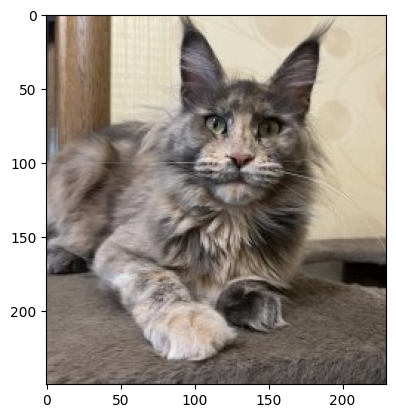

In [21]:
test_lzw(cat)

Розмір зображенння: Ширина - 1920 , Висота - 1080
RGB чи напівтонове: RGB
Розмір зображення в бітах: 47565139
Кількість закодованих значень (розмір списку) -  1471106
Розмір закодованого зображення в бітах: 25673441
Розмір декодованого зображенння: Ширина - 1920 , Висота - 1080
Чи декодоване зображення ідентичне до оригінального: True
Коефіцієнт стиснення -  1.8526982417354962
Закодоване зображення займає 53.98 % оригінального зображення


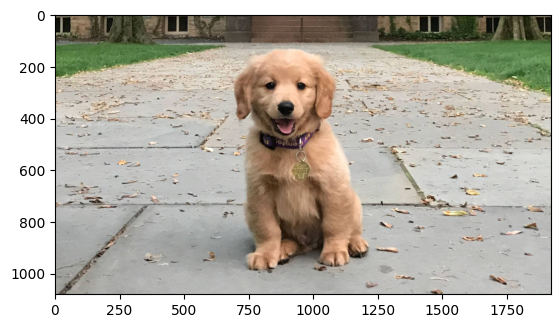

In [22]:
test_lzw(dog)

Розмір зображенння: Ширина - 1280 , Висота - 795
RGB чи напівтонове: RGB
Розмір зображення в бітах: 20806224
Кількість закодованих значень (розмір списку) -  890262
Розмір закодованого зображення в бітах: 14634324
Розмір декодованого зображенння: Ширина - 1280 , Висота - 795
Чи декодоване зображення ідентичне до оригінального: True
Коефіцієнт стиснення -  1.4217413800596461
Закодоване зображення займає 70.34 % оригінального зображення


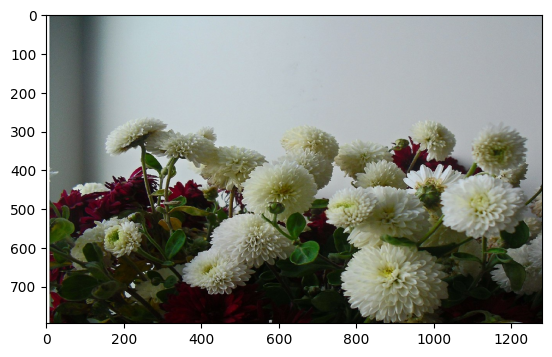

In [23]:
test_lzw(flowers)

In [ ]:
dog

array([[[ 27,  20,  10],
        [ 25,  18,   8],
        [ 24,  17,   7],
        ...,
        [ 25,  19,   7],
        [ 32,  26,  14],
        [ 38,  32,  20]],

       [[ 35,  28,  18],
        [ 32,  26,  14],
        [ 30,  23,  13],
        ...,
        [ 35,  29,  17],
        [ 41,  35,  23],
        [ 45,  39,  27]],

       [[ 49,  43,  31],
        [ 47,  41,  27],
        [ 45,  39,  27],
        ...,
        [ 52,  46,  32],
        [ 57,  51,  37],
        [ 61,  55,  41]],

       ...,

       [[166, 168, 165],
        [166, 168, 165],
        [167, 167, 165],
        ...,
        [190, 192, 189],
        [191, 193, 190],
        [192, 194, 191]],

       [[167, 169, 166],
        [167, 169, 166],
        [168, 168, 166],
        ...,
        [190, 192, 189],
        [191, 193, 190],
        [192, 194, 191]],

       [[168, 170, 167],
        [168, 170, 167],
        [168, 168, 166],
        ...,
        [190, 192, 189],
        [191, 193, 190],
        [192, 194, 191]]

In [ ]:
q = image_to_1d(dog)

In [ ]:
w = lzw_encode(q)

In [ ]:
e = lzw_decode(w)

In [ ]:
r = image_to_origin(e)

In [ ]:
r = r.astype(np.uint8)
r

array([[[ 27, 197, 198],
        [ 25, 198, 197],
        [ 24, 198, 195],
        ...,
        [ 27, 125, 191],
        [ 25, 127, 191],
        [ 22, 129, 191]],

       [[ 19, 130, 191],
        [ 18, 131, 193],
        [ 21, 128, 193],
        ...,
        [120,  82,  51],
        [119,  84,  61],
        [118,  82,  74]],

       [[117,  76,  81],
        [116,  71,  81],
        [116,  67,  54],
        ...,
        [ 66,  37, 100],
        [ 78,  40, 105],
        [ 99,  43, 109]],

       ...,

       [[191, 181, 179],
        [191, 181, 179],
        [190, 181, 179],
        ...,
        [181, 191, 192],
        [184, 192, 194],
        [184, 194, 195]],

       [[183, 195, 197],
        [183, 192, 198],
        [185, 189, 196],
        ...,
        [193, 191, 185],
        [194, 191, 187],
        [191, 192, 182]],

       [[192, 193, 183],
        [192, 194, 185],
        [193, 195, 186],
        ...,
        [197, 198, 196],
        [197, 197, 196],
        [196, 196, 196]]

In [ ]:
np.array_equal(r, dog)

False